# Table of contents

### - Import libraries and define functions + Initial setup

# Import libraries and define functions + Initial setup

In [1]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
import csv
from scipy import stats
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import os
import glob


## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
'''
function name: get_real_transcript_length

purpose: create dataframe containing exonic transcript length and transcript_id

input: bambu gtf file

output: dataframe with two columns, transcript_id and real_transcript_length
'''

def get_real_transcript_length(annotation):
    
    annotation = parse_df_columns(annotation, is_ref=False)
    
    annotation["real_transcript_length"] = abs(annotation["end"] - annotation["start"])
    
    exon_annotation = annotation.loc[annotation["type"] == "exon"][["transcript_id", "real_transcript_length"]].copy()
    
    df_transcript_length = exon_annotation.groupby("transcript_id").sum()
    
    df_transcript_length.reset_index(inplace=True)
    
    return df_transcript_length    

In [3]:
"""
Convert a hexadecimal color representation to an RGB tuple.

Parameters:
hex_color (str): The color in hexadecimal format. Can start with or without a hash (#).
                  It should be 6 characters long, with each pair representing red, green,
                  and blue color channels respectively.

Returns:
tuple: A tuple containing three integers representing the red, green, and blue color
       values ranging from 0 to 255.
"""

def hex_to_rgb(hex_color: str) -> tuple:

    # Remove the hash at the start if it's there
    hex_color = hex_color.lstrip('#')
    # Convert hex to RGB by taking two characters at a time, and converting to decimal
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

In [4]:
'''
function name: get_real_transcript_length

purpose: create dataframe containing exonic transcript length and transcript_id

input: bambu gtf file

output: dataframe with two columns, transcript_id and real_transcript_length
'''

def get_real_transcript_length(annotation):
    
    annotation = parse_df_columns(annotation, is_ref=False)
    
    annotation["real_transcript_length"] = abs(annotation["end"] - annotation["start"])
    
    exon_annotation = annotation.loc[annotation["type"] == "exon"][["transcript_id", "real_transcript_length"]].copy()
    
    df_transcript_length = exon_annotation.groupby("transcript_id").sum()
    
    df_transcript_length.reset_index(inplace=True)
    
    return df_transcript_length    

In [5]:
'''
name: relative_transcript_abundance

purpose: calculate relative transcript abundance

input: a dataframe with a ref_gene_id column identifying the transcript gene of origin and a cov columns with 
the coverage for the transcripts.

output: the same dataframe with a relative abundance column added
'''



def relative_transcript_abundance(df):
    
    ## Group by gene_id and get total expression for each gene (not counting introns)
    df_sums = df[["gene_id", "total_CPM"]].groupby("gene_id").sum()
    df_sums["total_CPM_gene"] = df_sums["total_CPM"]
    df_sums.drop(columns="total_CPM", inplace=True)
    
    ## Merge dataframe with total gene level CPM with regular transcript level CPM dataframe
    merged_df = pd.merge(df, df_sums, how='inner', on="gene_id")
    
    ## Calculater relative percent abundance for each transcript within its gene
    merged_df["relative_abundance_percent"] = ((merged_df["total_CPM"]/merged_df["total_CPM_gene"]) * 100)
    
    ## Rename total_CPM for transcript column
    merged_df["total_CPM_transcript"] = merged_df["total_CPM"]
    merged_df.drop(columns="total_CPM", inplace=True)


    return merged_df

In [6]:
'''
function name: fix_column_names

purpose: Fixing the column names, making them smaller, informative, and consistent

input: The raw counts dataframe for either genes or transcripts 

output: Same dataframe with improved column names
'''

def fix_column_names(df, is_gene=False):
    
    ## Check if this is a gene counts object
    if is_gene:
        
        ## Get count column names and create list of new column names
        count_columns = df.columns.tolist()
        list_new_names = ["gene_id"]
        
        ## gene_id comes in as index for gene counts data, make it into the first column instead
        df["gene_id"] = df.index
        cols = list(df.columns)
        cols = [cols[-1]] + cols[:-1]
        df = df[cols]
        df.reset_index(inplace=True, drop=True)
    
    ## If it is a transcript dataset
    else:
        ## Set count columns and create list of new names
        count_columns = df.columns[2:].tolist()
        list_new_names = [ "transcript_id", "gene_id"]
    
    ## Fix names one by one and add to list of new names
    for col in count_columns:
        col = col.split("_mapped")[0] + "_counts"
        list_new_names.append(col)
    
    ## Rename columns
    df.columns = list_new_names
    
    return df 

In [7]:
'''
function name: parse_df_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True, is_transcript=False, is_prot=False):

    if is_ref:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)
        
        ## Get gene names
        df["gene_name"] = df["other"].str.split("gene_name \"", expand=True)[1].str.split('\";', expand=True)[0]
        
        ## Get get transcript biotype
        df["gene_biotype"] = df["other"].str.split('gene_biotype "', expand=True)[1].str.split('"', expand=True)[0]
        
        ## If is transcript get transcript id and transcript biotype
        if is_transcript:
            df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]
            df["transcript_biotype"] = df["other"].str.split('transcript_biotype "', expand=True)[1].str.split('"', expand=True)[0]
            
            ## If is prot get protein_id
            if is_prot:
                df["protein_id"] = df["other"].str.split('protein_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["ccds_id"] = df["other"].str.split('ccds_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)
        

    else:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)

        ## Get transcript ids
        df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]

        ## Get exon number
        df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)

    for col in df.columns:
        df.loc[df[col].isnull(), col] = np.NaN
        

    return df

In [8]:
'''
function name: calculate_cpm

purpose: Calculate CPM for the each sample given

input: Counts dataset

output: Counts dataset with CPM columns as well
'''

def calculate_cpm(df, is_gene=False):

    ## Set count columns if dataframe is gene counts
    if is_gene:
        count_columns = df.columns[1:].tolist()
    
    ## Set count columns if dataframe is transcript counts
    else:
        count_columns = df.columns[2:].tolist()

    ## Loop through counts columns to calculate CPM and add to the dataframe
    for col in count_columns:
        
        df[col] = round(df[col], 2)
        cpm_name = col.replace("_counts", "_CPM")
        df[cpm_name] = round(((df[col]/(df[col].sum())) * 1000000), 2)
    
    return df  

In [9]:
"""
This function loads all salmon quant.sh files with the given filename from all subdirectories 
of the provided parent directory and returns a merged counts and a merged TPM matrix.

Parameters:
filename (str): The name of the salmon file to load
parent_directory (str): The path to the parent directory containing the folders with salmon quant.sf files.

Returns:
list: A merged counts and a merged TPM matrix.
"""
    
def load_salmon_data_and_merge(filename, parent_directory):

    dataframes = []

    # Create a path pattern to find all folders containing the TSV files
    folder_pattern = os.path.join(parent_directory, '*', filename)

    # Get a list of all TSV files matching the pattern
    tsv_files = glob.glob(folder_pattern)
    
    ## Create flag for first iteration of loop
    flag_first = True
    
    # Read each TSV file into a DataFrame and append it to the list
    for tsv_file in tsv_files:
        
        ## Create column names
        sample_name = tsv_file.split("/")[-2].split("_Aligned")[0]
        tpm_name = sample_name + "_TPM"
        counts_name = sample_name + "_counts"
        
        ## Open dataframe for counts and TPM
        df_counts = pd.read_csv(tsv_file, sep='\t', usecols=[0, 4], names=["transcript_id", counts_name],
                               low_memory=False, header=0)
        df_tpm = pd.read_csv(tsv_file, sep='\t', usecols=[0, 3], names=["transcript_id", tpm_name], 
                             low_memory=False, header=0)
                
        ## If it is not the first iteration just add to merged dataframes
        if flag_first == False:
            
            df_meged_counts = df_meged_counts.merge(df_counts, on="transcript_id", how="inner")
            df_meged_tpm = df_meged_tpm.merge(df_tpm, on="transcript_id", how="inner")
        
        ## If it is the first iteration set merged dataframe to first dataframes
        ## Set flag_first to false
        else:
            
            df_meged_counts = df_counts.copy()
            df_meged_tpm = df_tpm.copy()
            
            flag_first = False
            
        df_meged_counts.shape
           

    return df_meged_counts, df_meged_tpm

In [10]:
## define ggplot colors
ggplot2_colors = ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"]

## - Pre-process data

In [11]:
## Open original reference
ref = pd.read_csv("../../../data/raw/nextflow_pipeline_output/bambu_discovery/extended_annotations.gtf", 
                  header=None, delimiter="\t", low_memory=False, 
                    names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"], comment="#")

ref_copy = ref.copy()

ref_transcript_length = get_real_transcript_length(ref_copy)

ref = parse_df_columns(ref, is_ref=False)

ref = ref.loc[ref["type"]=="transcript"].copy()

In [12]:
## Set parent directory and salmon quantification file name
parent_dir = "../../../data/raw/1st_rebuttal_data/CSHL_illumina_uky_aged_brain_with_our_extended_annotation_UNIQUE/salmon_alignment_mode/"
name = "quant.sf"

## Create merged dataframe with counts and tpm
df_unique_ill, df_tpm_unique = load_salmon_data_and_merge(name, parent_dir)

In [13]:
## Set parent directory and salmon quantification file name
parent_dir = "../../../data/raw/1st_rebuttal_data/CSHL_illumina_uky_aged_brain_with_our_extended_annotation/salmon_alignment_mode/"
name = "quant.sf"

## Create merged dataframe with counts and tpm
df_ill, df_tpm_ill = load_salmon_data_and_merge(name, parent_dir)

In [14]:
## Import counts matrices

df_ont = pd.read_csv("../../../data/raw/nextflow_pipeline_output/bambu_discovery/counts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

df_unique_ont = pd.read_csv("../../../data/raw/nextflow_pipeline_output/bambu_discovery/uniqueCounts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

In [15]:
## Fix column names
df_ont = fix_column_names(df_ont, is_gene=False)
df_unique_ont = fix_column_names(df_unique_ont, is_gene=False)

In [16]:
## Calculate CPM and drop count columns
df_cpm = calculate_cpm(df_ont.copy(), is_gene=False)

df_cpm = df_cpm[df_cpm.columns.drop(list(df_cpm.filter(regex='counts')))].copy()

## Drop ERCCs
df_cpm = df_cpm.loc[~df_cpm["gene_id"].str.startswith("ERCC")].copy()

## Calculate median CPM
df_cpm["median_CPM"] = df_cpm[df_cpm.filter(regex='[0-9]_CPM').columns].median(axis=1)


## Find transcript_ids for median_CPM > 1 transcripts
df_cpm = df_cpm.loc[df_cpm["median_CPM"] > 1].copy()

transcript_ids_cpm_1 = df_cpm["transcript_id"].copy()

In [17]:
## Only keep transcript ids for median CPM > 1

df_ont = df_ont.loc[df_ont["transcript_id"].isin(transcript_ids_cpm_1)].copy()

df_ill = df_ill.loc[df_ill["transcript_id"].isin(transcript_ids_cpm_1)].copy()

df_unique_ont = df_unique_ont.loc[df_unique_ont["transcript_id"].isin(transcript_ids_cpm_1)].copy()

df_unique_ill = df_unique_ill.loc[df_unique_ill["transcript_id"].isin(transcript_ids_cpm_1)].copy()

In [18]:
## Only keep relevant columns

df_ont = df_ont[['transcript_id', 'gene_id', 'sample_1218_PAM43779_counts',
       'sample_1304_PAM44487_counts', 'sample_1271_PAM44815_counts',
       'sample_5356_PAM42933_counts']].copy()

df_unique_ont = df_unique_ont[['transcript_id', 'gene_id', 'sample_1218_PAM43779_counts',
       'sample_1304_PAM44487_counts', 'sample_1271_PAM44815_counts',
       'sample_5356_PAM42933_counts']].copy()

In [19]:
## Calculate total counts

df_ont["total_counts"] = df_ont[df_ont.filter(regex='counts').columns].sum(axis=1)

df_ill["total_counts"] = df_ill[df_ill.filter(regex='counts').columns].sum(axis=1)

df_unique_ont["total_unique_counts"] = df_unique_ont[df_unique_ont.filter(regex='counts').columns].sum(axis=1)

df_unique_ill["total_unique_counts"] = df_unique_ill[df_unique_ill.filter(regex='counts').columns].sum(axis=1)

In [20]:
## Define technology

df_ont["Technology"] = "Nanopore"

df_ill["Technology"] = "Illumina"

df_unique_ont["Technology"] = "Nanopore"

df_unique_ill["Technology"] = "Illumina"

In [21]:
## Merge and only keep relevant columns

df_merged_ont = df_ont[["gene_id", "transcript_id", "total_counts", "Technology"]].merge(df_unique_ont[["transcript_id", 
                                                                            "total_unique_counts", "Technology"]],
                                                                           on=["transcript_id", "Technology"],
                                                                                         how="inner")


df_merged_ill = df_ill[["transcript_id", "total_counts", "Technology"]].merge(df_unique_ill[["transcript_id", 
                                                                            "total_unique_counts", "Technology"]],
                                                                           on=["transcript_id", "Technology"],
                                                                                         how="inner")


df_merged_ill = df_merged_ill.merge(df_ont[["gene_id", "transcript_id"]], on="transcript_id", how="inner")

In [22]:
## Concatenate files

df_merged = pd.concat([df_merged_ont, df_merged_ill])

In [23]:
## Calculate percent unique counts
df_merged["percent_unique_counts"] = ((df_merged["total_unique_counts"]/df_merged["total_counts"]) * 100)

In [24]:
## Add real transcript length

df_with_length = df_merged.merge(ref_transcript_length, on="transcript_id", how="inner")

In [25]:
## Create reference copy
ref2 = ref[["gene_id", "transcript_id"]].copy()

In [26]:
## Count number of transcripts per gene_id
num_transcripts = ref2["gene_id"].value_counts().reset_index()
num_transcripts.columns = ['gene_id', 'number_of_annotated_transcripts']

In [27]:
## Make it so it only goes to 6+

num_transcripts.loc[num_transcripts["number_of_annotated_transcripts"] >= 10, "number_of_annotated_transcripts"] = "≥10"

## Convert column to string
num_transcripts["number_of_annotated_transcripts"] = num_transcripts["number_of_annotated_transcripts"].astype(str)

In [28]:
## Merge to add number of annotated transcripts

df_with_length = df_with_length.merge(num_transcripts, how="inner", on="gene_id")

## - Make Plots

In [29]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)


# figure size in inches
rcParams['figure.figsize'] = (170*mm, 85*mm)
rcParams.update({'font.size': 7})
rcParams['axes.linewidth'] = 1

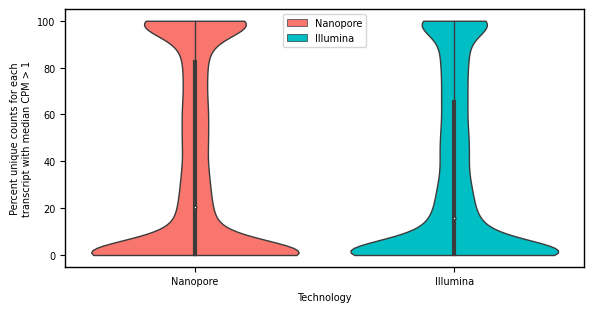

In [30]:
## Make violin plot

violin = sns.violinplot(data=df_with_length, y="percent_unique_counts", x="Technology", hue="Technology",
           saturation=1, palette=[ggplot2_colors[0], ggplot2_colors[4]] , cut=0,
           showfliers=False,linewidth=1, dodge=False)


plt.legend(loc="upper center")

plt.ylabel("Percent unique counts for each\ntranscript with median CPM > 1")

plt.savefig('../../../figures/1st_rebuttal_figures/illumina_unique_vs_ont_unique/percent_unique.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

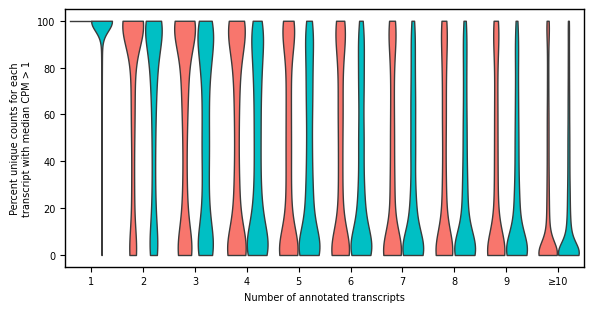

In [31]:
violin = sns.violinplot(data=df_with_length, y="percent_unique_counts", x="number_of_annotated_transcripts",
           saturation=1, palette=[ggplot2_colors[0], ggplot2_colors[4]] ,  inner=None, cut=0,
           showfliers=False,linewidth=1, hue="Technology",
           order=["1", "2", "3", "4", "5", "6", "7", "8", "9", "≥10"], dodge=True)


plt.ylabel("Percent unique counts for each\ntranscript with median CPM > 1")
plt.xlabel("Number of annotated transcripts")

violin.get_legend().remove()

plt.savefig('../../../figures/1st_rebuttal_figures/illumina_unique_vs_ont_unique/percent_unique_across_number_of_annotated_transcripts.pdf',
            dpi=600, transparent=True, bbox_inches="tight")